In [1]:
import numpy as np 
%matplotlib ipympl 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_interactions import image_segmenter
import ipywidgets as widgets
from ipyfilechooser import FileChooser
import pandas as pd
import os
import warnings
from itertools import zip_longest
warnings.filterwarnings('ignore')

## Preamble: Useful functions (to run)

In [2]:
def clean_df(df): 
    """Makes sure that df elements are floats and replaces
    inf with nan for easier data manipulation."""
    a = df.astype(float).replace([-np.inf,+np.inf],np.nan)
    return a

# Introduction
This notebook allows to visualise and manipulate Brillouin Spectroscopy maps (in terms of frequency shift, $\nu_B$) acquired and processed using the light machinery set-up (https://lightmachinery.com/). In brief, the "Scan_Parameters_and_Analysis.csv" file is first imported and manipulated so that the Brillouin map ($\nu_B$) can be shown as a color map with appropriate $x$ and $y$ coordinates. Then, $\nu_B$ profiles are shown along both $x$ and $y$ as line plots. Finally, the possibility to isolate the background from the objects of interest (e.g., cells, spheroids etc) is given using a simple threshold (main branch) or by manual segmentation; and the average of both background and/or object can be computed and saved. <br> 
The notebook has been made interactive via widgets to be more user friendly. A step by step workflow is summarised below: 

### 1) Run cell below to upload the  "Scan_Parameters_and_Analysis.csv" file 

In [3]:
fc = FileChooser()
display(fc)

FileChooser(path='/Users/giuseppeciccone/Library/CloudStorage/OneDrive-UniversityofGlasgow/PhD/PyModules/brill…

### 2) Run cells below to clean data
Because the "Scan_parameters_and_Analysis.csv" file contains processed data from the light machinery acquisition software (i.e., frequency shift and full width half maximum obtained by fitting spectra with a Lorentzian), we need to clean some data originating from failed fits. These include NaN, infinity and outlier values.
The clean_df function transorms infinity values into nans, which can be handled by most functions. However,
specific outliers values are difficult to remove (maps are usually composed of two objects - background and spheroid). Because of this, the cells below ask you whether your data contains outliers (obvious from the 2d map) and if yes, you can selct a range of frequencies of interest where most data lies. An example of a map with one outlier skewing all the data is shown below: 
<center><img src=images/outliers.png  width=40% height=40%>

The cell below will display the acquired map. If you think the map looks suspicious (i.e., contains outliers), select "Yes" below and then choose a range of frequencies you want to restric your data in based on its 2D histogram. If the map looks ok, then the origianl data will be used!

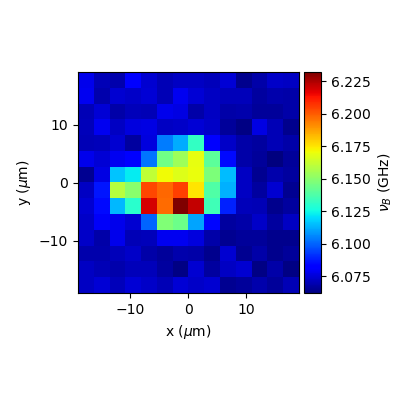

In [4]:
#Read data and create sub-data frame with X, Y and Shift; add columns in um (from mm)
data = pd.read_csv(fc.selected)
datasub = data[[" X (mm)", " Y (mm)", " Shift (GHz)"]]
datasub["X (um)"]=datasub.iloc[:,0]* 1000.0
datasub["Y (um)"]=datasub.iloc[:,1]* 1000.0
#Pivot sub-data frame so that it can be plotted as a map with correct x and y coordinates
piv=datasub.pivot(index = "Y (um)",columns="X (um)",values=" Shift (GHz)")
piv=clean_df(piv)
fig,ax = plt.subplots(1,1, figsize=(4,4))
im = ax.imshow(piv,cmap="jet",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=0.05)
plt.colorbar(mappable=im,ax=ax,cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
fig.tight_layout()
ax.grid(False)
plt.show()

In [6]:
outliersw = widgets.Dropdown(
    options=[('Yes', True), ('No', False)],
    value=False,
    description='Outliers?:',
)
display(outliersw)

Dropdown(description='Outliers?:', index=1, options=(('Yes', True), ('No', False)), value=False)

In [7]:
def screen_outliers(v_min=5.9,v_max=6.5):
    fig,axs = plt.subplots(1,2, figsize=(10,5))
    cond = ((piv > v_min) & (piv < v_max))
    axs[0].hist(np.array(piv[cond]).flatten(),bins="auto")
    axs[0].axvline(v_min,c='r')
    axs[0].axvline(v_max,c='r')
    im1=axs[1].imshow(piv[cond],cmap="jet",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
    titles = ["2D histogram","Image"]
    for i,ax in enumerate(axs):
        ax.set_title(titles[i])
        ax.grid(False)
        if i == 0:
            ax.set_ylabel("Counts")
            ax.set_xlabel(r"$\nu_B$ (GHz)")
            #skip color map for histogram
            continue
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='8%', pad=0.05)
        ax.set_xlabel("x $(\mu m)$")
        ax.set_ylabel("y $(\mu m)$")
        plt.colorbar(mappable=im1,ax=axs[1],cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
    fig.tight_layout()
if outliersw.value is True: 
    screen_outliers_interactive= widgets.interactive(screen_outliers,v_min=(0,6.5,0.1),v_max=(5,8,0.1))
    display(screen_outliers_interactive)
    v_min_cond = screen_outliers_interactive.kwargs["v_min"]
    v_max_cond = screen_outliers_interactive.kwargs["v_max"]
    piv = piv[((piv>v_min_cond) & (piv<v_max_cond))]
else:
    piv = piv 

### 2) Run cell below to display cleaned Brillouin map 

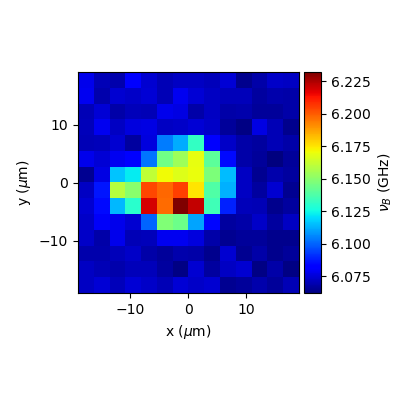

In [8]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
im = ax.imshow(piv,cmap="jet",extent=[min(datasub["X (um)"]),max(datasub["X (um)"]),min(datasub["Y (um)"]),max(datasub["Y (um)"])])
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='8%', pad=0.05)
plt.colorbar(mappable=im,ax=ax,cax=cax,fraction=0.05,label=r"$\nu_B$ (GHz)")
fig.tight_layout()
ax.grid(False)
plt.show()

### 3) Run cell below to display line profiles along x and  y

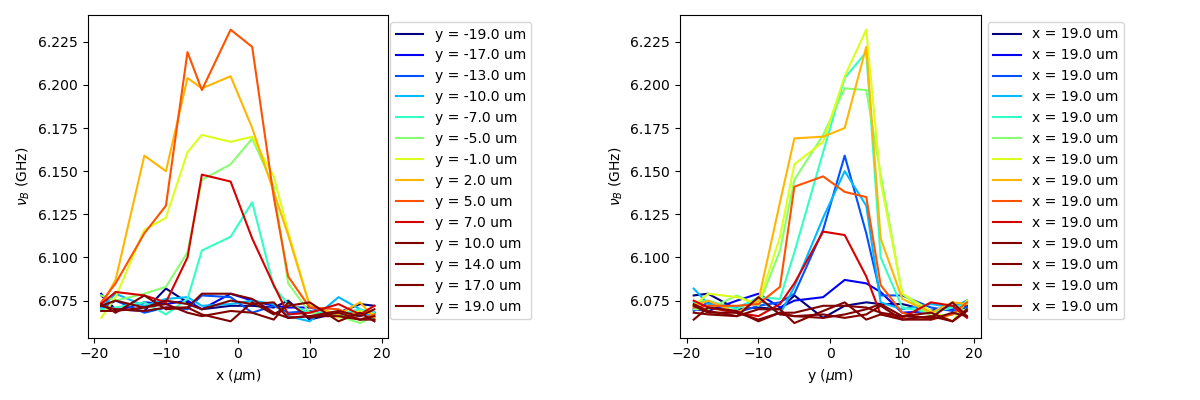

In [9]:
#Plot profiles along X and Y
fig, axs = plt.subplots(1,2,figsize=(12,4))
color = cm.jet(np.linspace(0,20,len(datasub["Y (um)"])))
for i,y in enumerate(piv.index):
    axs[0].plot(piv.columns,piv.loc[y,:],color=color[i],label="y = " +str(y)+ " um")
axs[0].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axs[0].set_xlabel("x ($\mu$m)")

color = cm.jet(np.linspace(0,20,len(datasub["X (um)"])))
for i,x in enumerate(piv.columns):
    axs[1].plot(piv.index,piv.loc[:,x],color=color[i],label="x = " +str(y)+ " um")
axs[1].legend(loc='upper right', bbox_to_anchor=(1.5, 1))
axs[1].set_xlabel("y ($\mu$m)")

for ax in axs: 
    ax.set_ylabel(r"$\nu_B$ (GHz)")
    ax.grid(False)
fig.tight_layout()
plt.show()

### 4) Run cell below in order to segment the Brillouin map <br> 

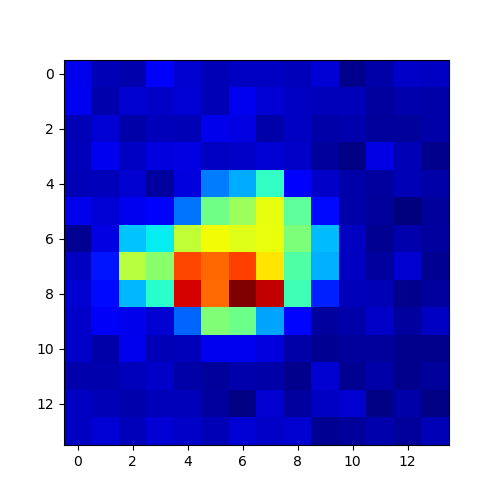

In [11]:
segmenter = image_segmenter(np.array(piv),cmap="jet", mask_colors="red", lineprops={"color": "black", "linewidth": 2, "alpha":1 },
                            mask_alpha=0.6, figsize=(5, 5))
display(segmenter)                      

And print the mean and std of the semgneted object:

In [12]:
pivarr = np.array(piv)
#segmenter.mask contains floats. To use it as a mask, it needs to contain integers (or booleans) 
usable_mask = segmenter.mask.astype(bool)
cell = pivarr[usable_mask]
avg_cell = np.mean(cell)
std_cell = np.std(cell)
print("Object's Average BrillouinShift p/m 1SD (GHz):{mean_object: .3f} p/m {sd_object:.3f}".format(mean_object=avg_cell, sd_object=std_cell))

Object's Average BrillouinShift p/m 1SD (GHz): 6.146 p/m 0.043
